# Football Match Prediction

In [134]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb


# Disable warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading

In [121]:
# Set the base data path
DATA_PATH = Path('data')

try:
    # Load training data
    print("\nLoading Training Data:")
    train_home_player = pd.read_csv(DATA_PATH / 'Train_Data' / 'train_home_player_statistics_df.csv', index_col=0)
    train_home_team = pd.read_csv(DATA_PATH / 'Train_Data' / 'train_home_team_statistics_df.csv', index_col=0)
    train_away_player = pd.read_csv(DATA_PATH / 'Train_Data' / 'train_away_player_statistics_df.csv', index_col=0)
    train_away_team = pd.read_csv(DATA_PATH / 'Train_Data' / 'train_away_team_statistics_df.csv', index_col=0)

    # Add prefixes to columns for team and player statistics
    for df, prefix in [(train_home_team, 'HOME_'), (train_home_player, 'HOME_'),
                      (train_away_team, 'AWAY_'), (train_away_player, 'AWAY_')]:
        df.columns = [prefix + col if i > 1 else col for i, col in enumerate(df.columns)]
    
    # Load target variables
    y_train_path = DATA_PATH / 'Y_train_1rknArQ.csv'
    y_train_supp_path = DATA_PATH / 'benchmark_and_extras' / 'Y_train_supp.csv'
    
    print(f"\nLoading target variable {y_train_path.name}...")
    y_train_away_win = pd.read_csv(y_train_path, index_col=0)

    y_train =pd.read_csv(y_train_path, index_col=0)
    
    print(f"Loading supplementary target variable {y_train_supp_path.name}...")
    y_train_supp = pd.read_csv(y_train_supp_path, index_col=0)
    
    print("\nAll data loaded successfully.")

except FileNotFoundError as e:
    print(f"\nFile Not Found Error: {e}")
except pd.errors.EmptyDataError as e:
    print(f"\nEmpty Data Error: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

def display_sample_data():
    print("\nSample Data from Training Sets:")
    print("\nHome Player Statistics:")
    print(train_home_player.head())
    
    print("\nHome Team Statistics:")
    print(train_home_team.head())
    
    print("\nAway Player Statistics:")
    print(train_away_player.head())
    
    print("\nAway Team Statistics:")
    print(train_away_team.head())
    
    print("\nY_train:")
    print(y_train_away_win.head())
    
    print("\nY_train_supp:")
    print(y_train_supp.head())

display_sample_data()


Loading Training Data:

Loading target variable Y_train_1rknArQ.csv...
Loading supplementary target variable Y_train_supp.csv...

All data loaded successfully.

Sample Data from Training Sets:

Home Player Statistics:
     LEAGUE TEAM_NAME HOME_POSITION     HOME_PLAYER_NAME  \
ID                                                         
0   Ligue 1  Toulouse      defender        Agustín Rogel   
0   Ligue 1  Toulouse      defender    Mathieu Goncalves   
0   Ligue 1  Toulouse    goalkeeper      Baptiste Reynet   
0   Ligue 1  Toulouse    midfielder  Jean-Victor Makengo   
0   Ligue 1  Toulouse           NaN  Efthymios Koulouris   

    HOME_PLAYER_ACCURATE_CROSSES_season_sum  \
ID                                            
0                                       0.0   
0                                       0.0   
0                                       0.0   
0                                       8.0   
0                                       2.0   

    HOME_PLAYER_ACCURATE_PASSE

## EDA

--- Home Player Summary ---
Shape: (237079, 307)
Missing Values:
HOME_PLAYER_LONG_BALLS_WON_season_std          237079
HOME_PLAYER_LONG_BALLS_season_sum              237079
HOME_PLAYER_SHOTS_OFF_TARGET_season_sum        237079
HOME_PLAYER_CAPTAIN_season_average             237079
HOME_PLAYER_LONG_BALLS_season_average          237079
HOME_PLAYER_LONG_BALLS_WON_season_average      237079
HOME_PLAYER_SHOTS_OFF_TARGET_season_average    237079
HOME_PLAYER_CAPTAIN_season_std                 237079
HOME_PLAYER_LONG_BALLS_5_last_match_std        237079
HOME_PLAYER_LONG_BALLS_season_std              237079
dtype: int64
First Few Rows:
     LEAGUE TEAM_NAME HOME_POSITION     HOME_PLAYER_NAME  \
ID                                                         
0   Ligue 1  Toulouse      defender        Agustín Rogel   
0   Ligue 1  Toulouse      defender    Mathieu Goncalves   
0   Ligue 1  Toulouse    goalkeeper      Baptiste Reynet   
0   Ligue 1  Toulouse    midfielder  Jean-Victor Makengo   
0   Li

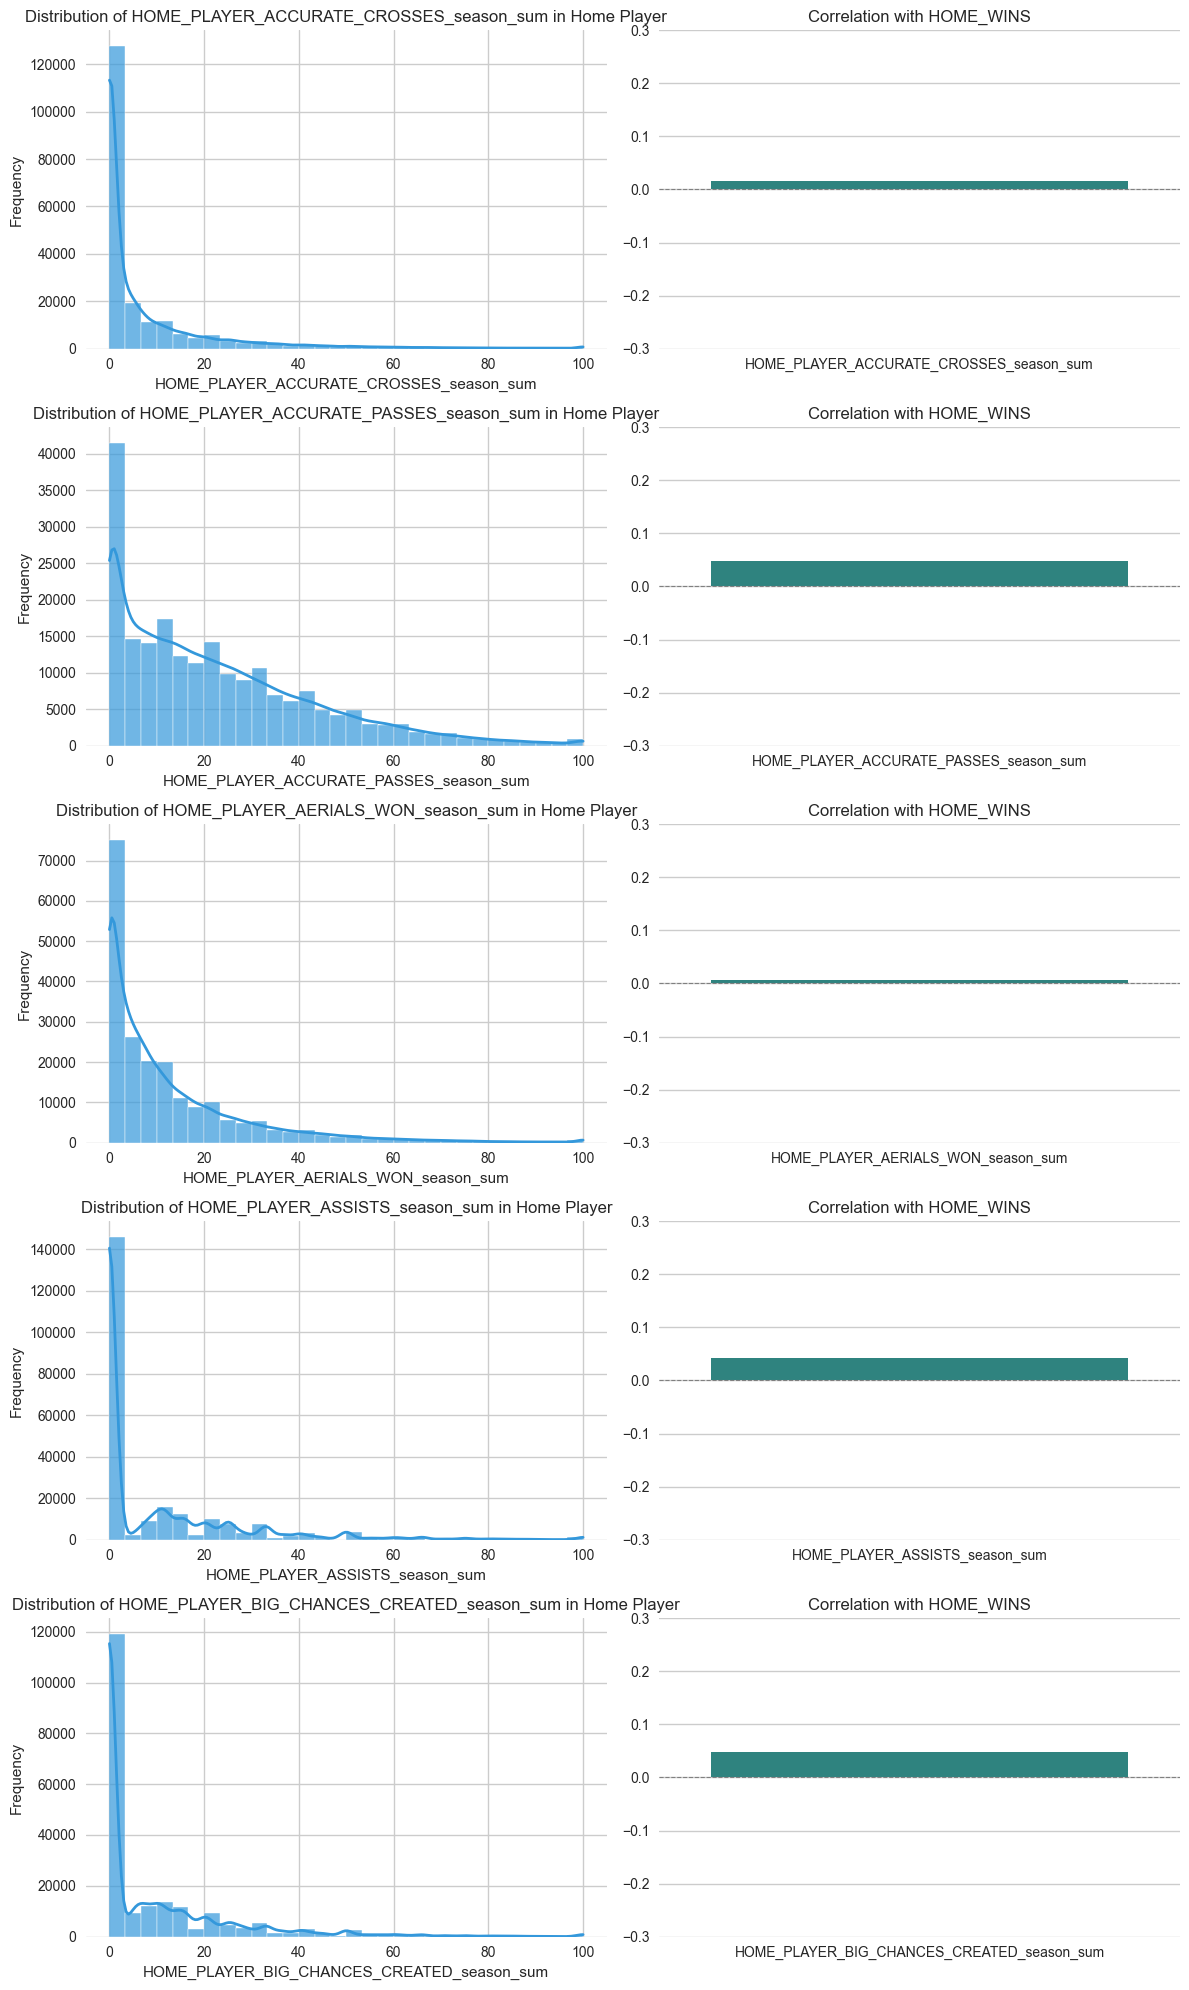

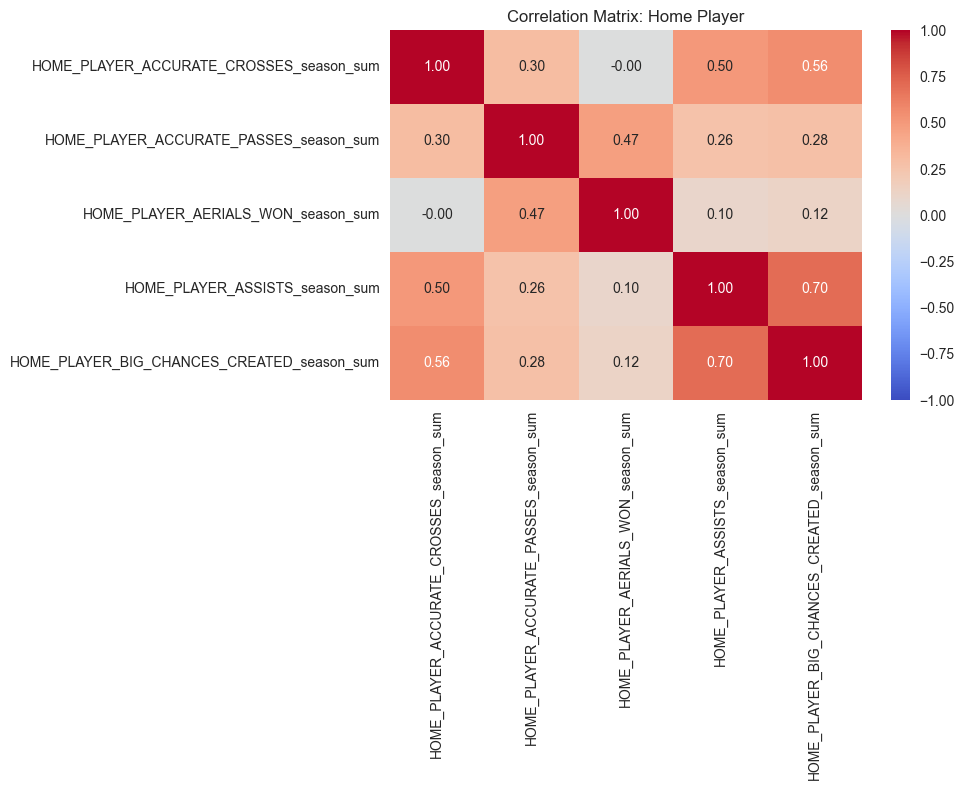

--- Away Player Summary ---
Shape: (236132, 307)
Missing Values:
AWAY_PLAYER_LONG_BALLS_WON_season_std          236132
AWAY_PLAYER_LONG_BALLS_season_sum              236132
AWAY_PLAYER_SHOTS_OFF_TARGET_season_sum        236132
AWAY_PLAYER_CAPTAIN_season_average             236132
AWAY_PLAYER_LONG_BALLS_season_average          236132
AWAY_PLAYER_LONG_BALLS_WON_season_average      236132
AWAY_PLAYER_SHOTS_OFF_TARGET_season_average    236132
AWAY_PLAYER_CAPTAIN_season_std                 236132
AWAY_PLAYER_LONG_BALLS_5_last_match_std        236132
AWAY_PLAYER_LONG_BALLS_season_std              236132
dtype: int64
First Few Rows:
     LEAGUE            TEAM_NAME AWAY_POSITION      AWAY_PLAYER_NAME  \
ID                                                                     
0   Ligue 1  Olympique Marseille      defender          Lucas Perrin   
0   Ligue 1  Olympique Marseille    midfielder       Kevin Strootman   
0   Ligue 1  Olympique Marseille    goalkeeper           Yohann Pelé   
0   Li

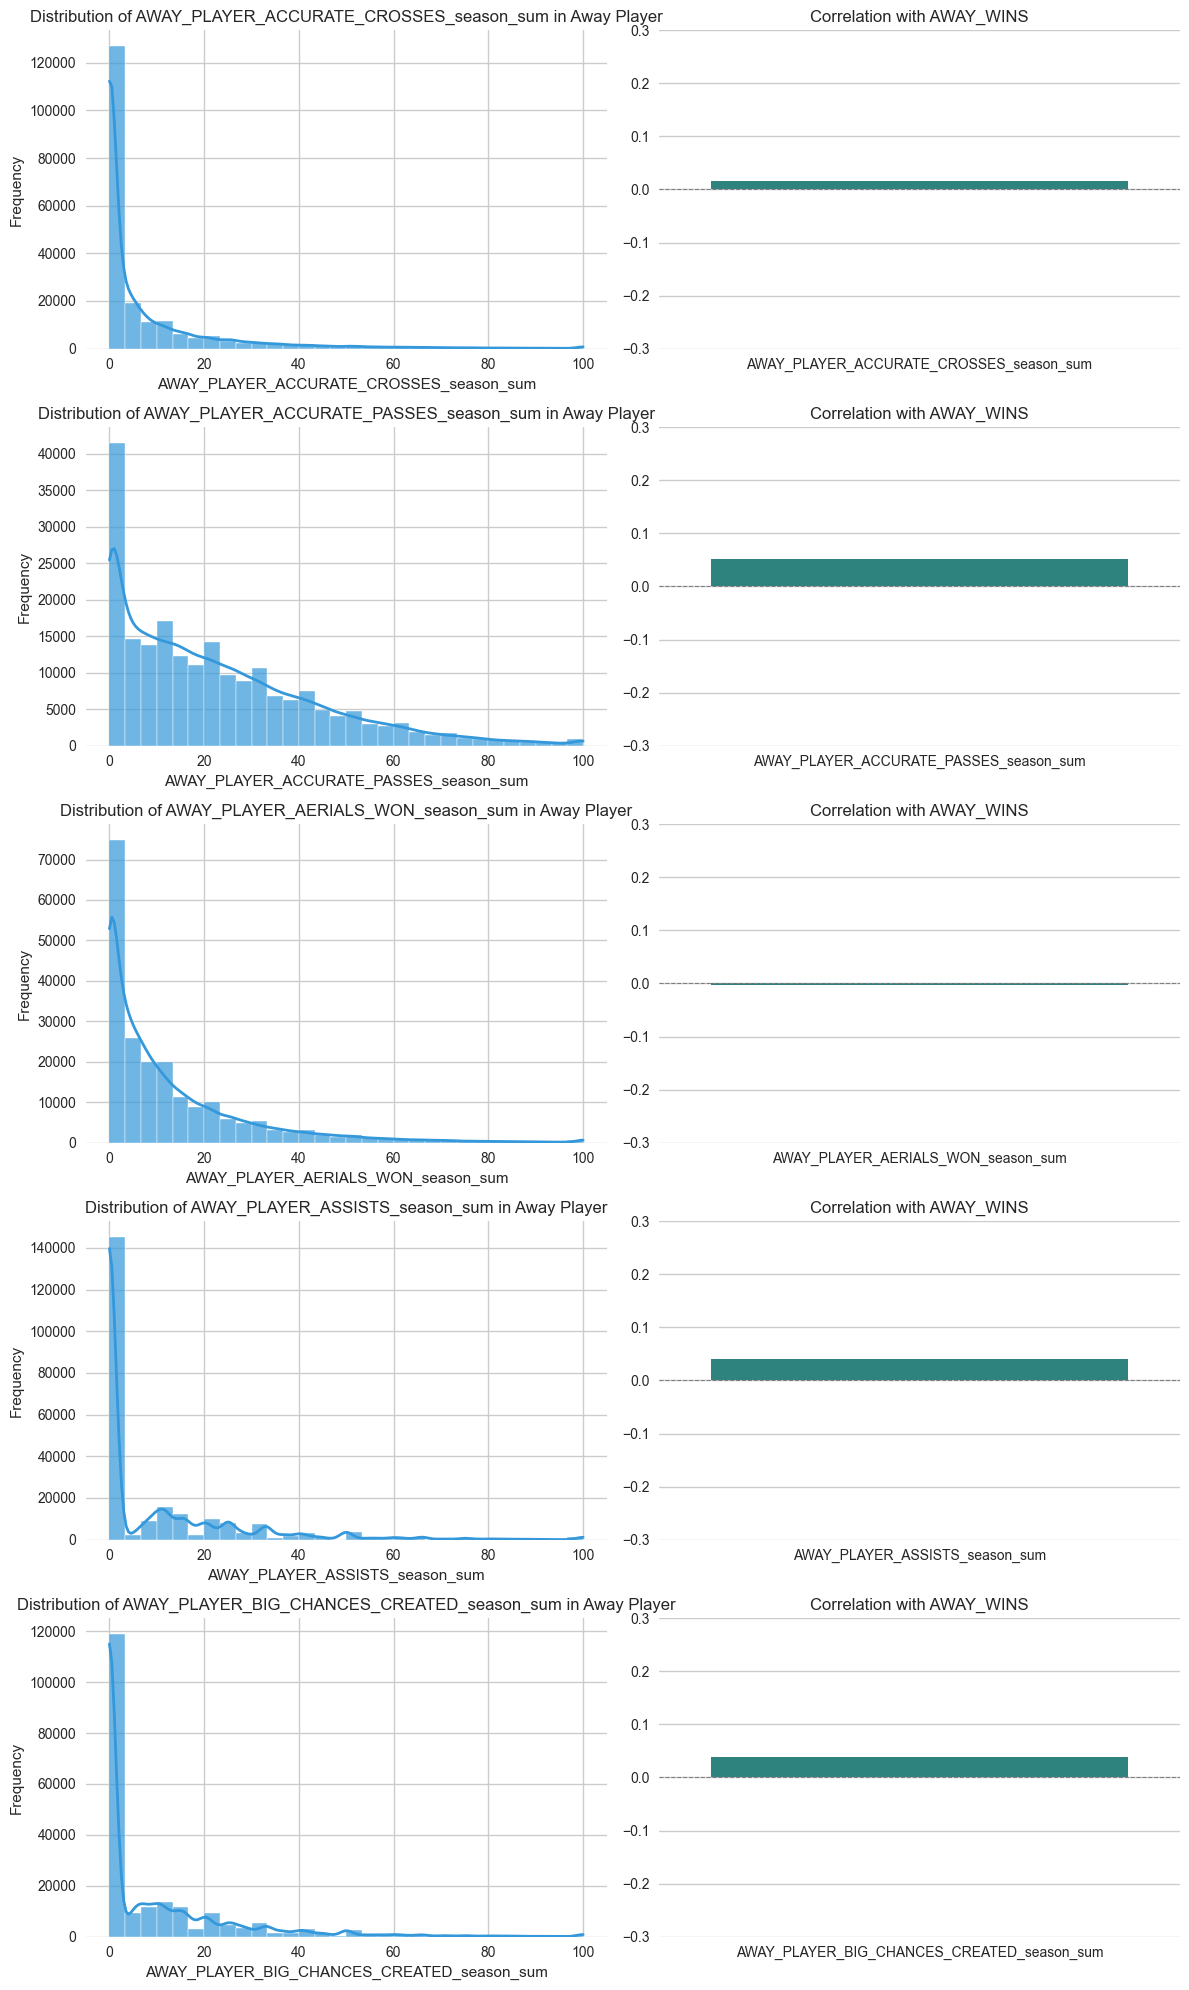

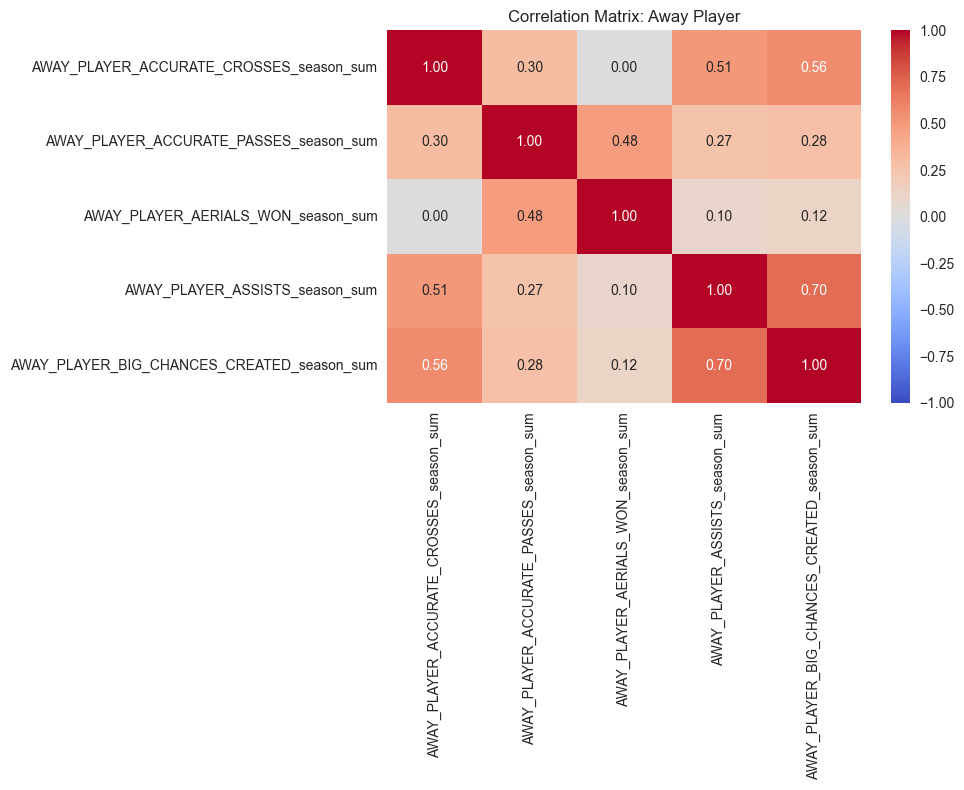

--- Home Team Summary ---
Shape: (12303, 143)
Missing Values:
HOME_TEAM_INJURIES_5_last_match_std                        3318
HOME_TEAM_INJURIES_5_last_match_sum                        2932
HOME_TEAM_INJURIES_5_last_match_average                    2931
HOME_TEAM_INJURIES_season_std                              2924
HOME_TEAM_INJURIES_season_sum                              1960
HOME_TEAM_INJURIES_season_average                          1959
HOME_TEAM_BALL_SAFE_5_last_match_std                       1795
HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std    1589
HOME_TEAM_PASSES_5_last_match_std                          1589
HOME_TEAM_PASSES_season_std                                1529
dtype: int64
First Few Rows:
            LEAGUE                TEAM_NAME  HOME_TEAM_SHOTS_TOTAL_season_sum  \
ID                                                                              
0          Ligue 1                 Toulouse                               3.0   
1          Ligue 2        

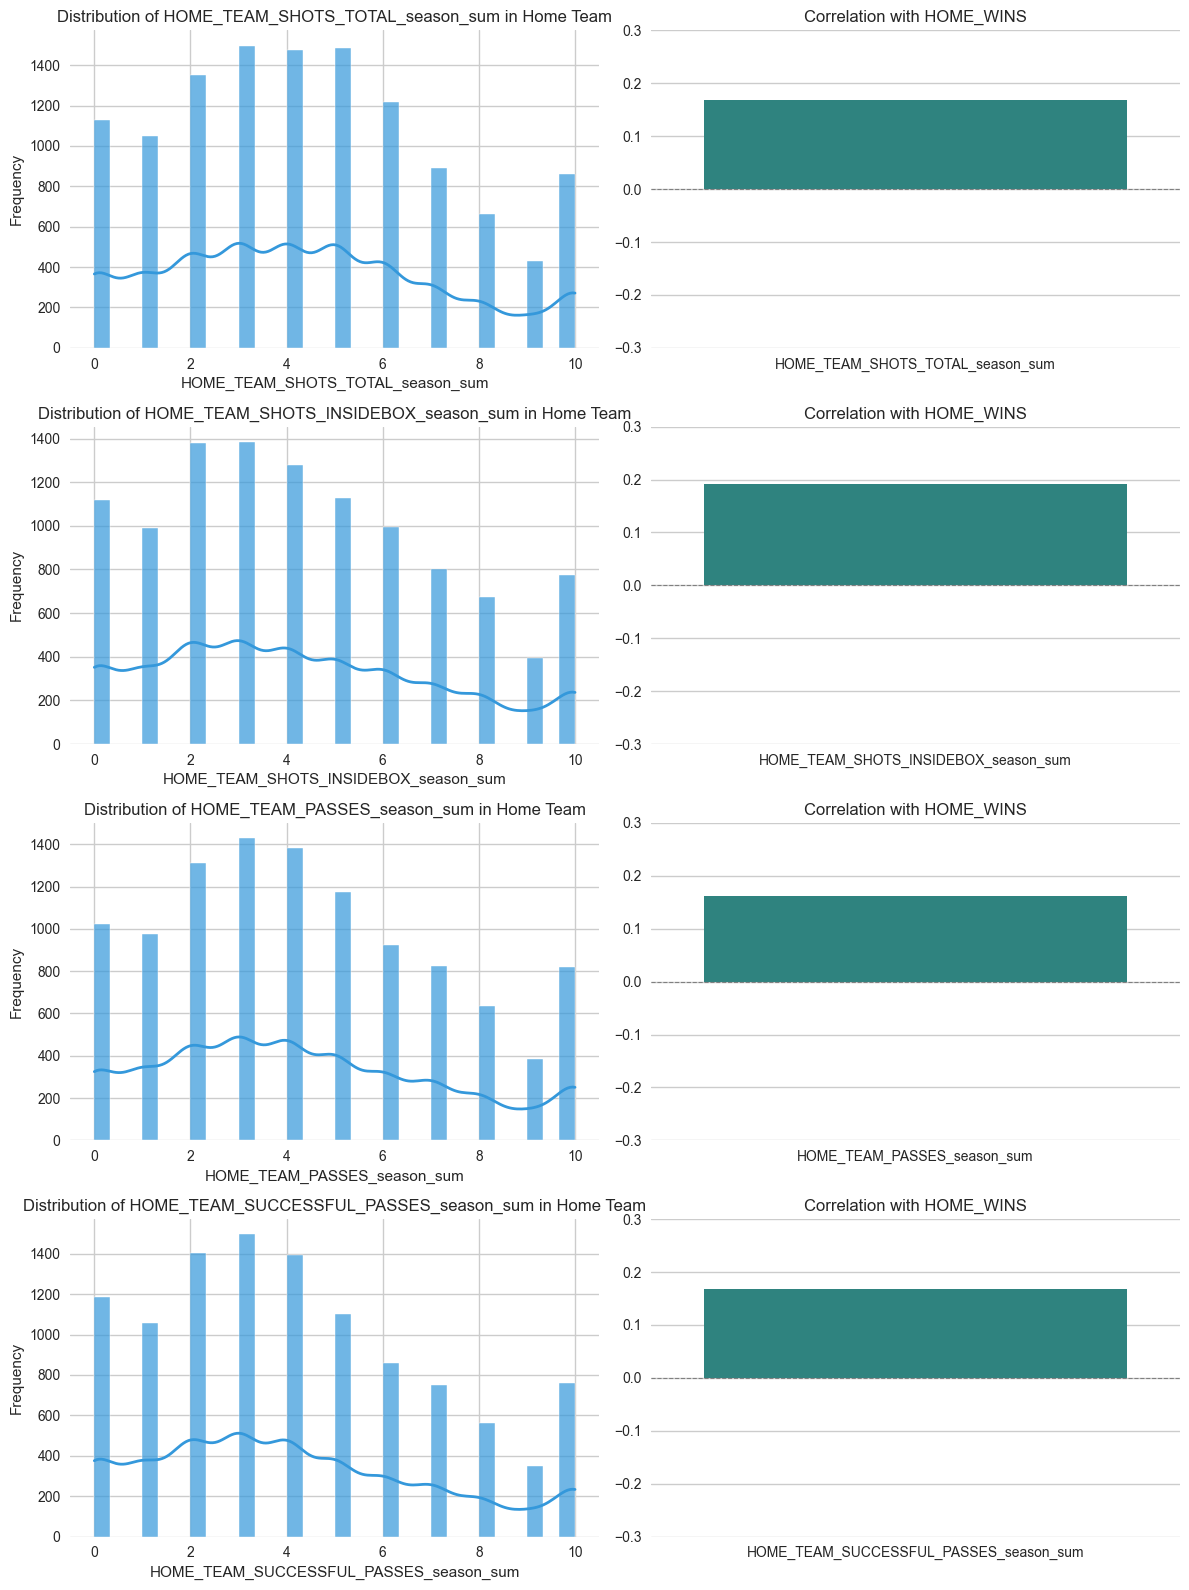

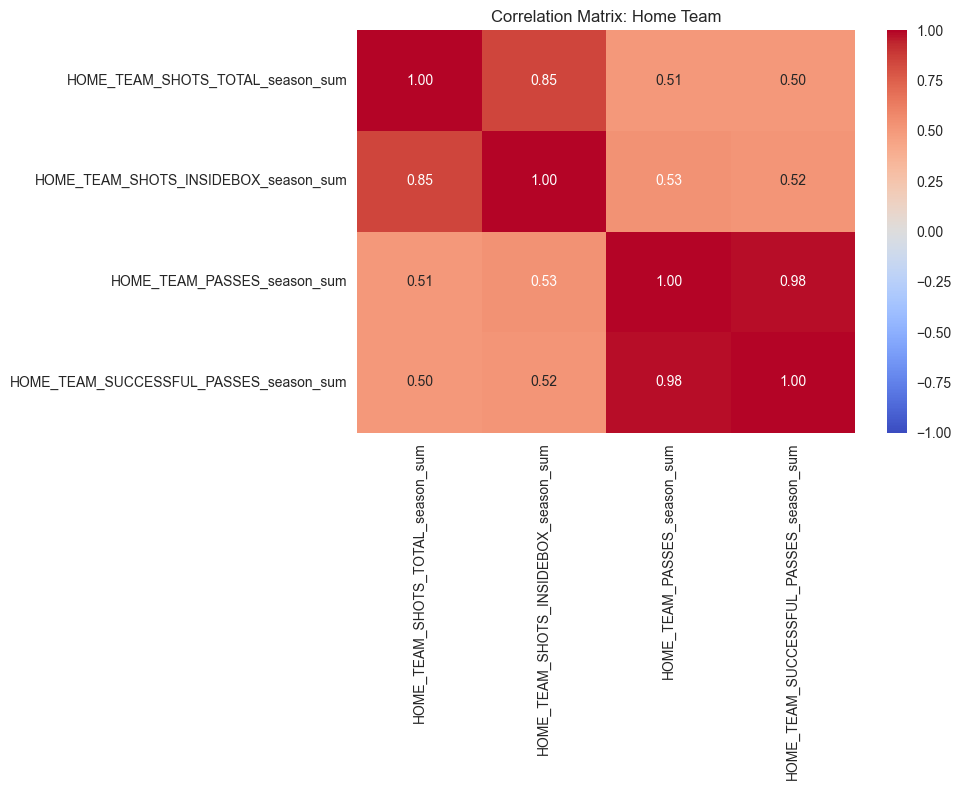

--- Away Team Summary ---
Shape: (12303, 143)
Missing Values:
AWAY_TEAM_INJURIES_5_last_match_std                        3313
AWAY_TEAM_INJURIES_5_last_match_sum                        2933
AWAY_TEAM_INJURIES_5_last_match_average                    2932
AWAY_TEAM_INJURIES_season_std                              2926
AWAY_TEAM_INJURIES_season_sum                              1961
AWAY_TEAM_INJURIES_season_average                          1960
AWAY_TEAM_BALL_SAFE_5_last_match_std                       1836
AWAY_TEAM_PASSES_5_last_match_std                          1588
AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std    1588
AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std          1529
dtype: int64
First Few Rows:
            LEAGUE            TEAM_NAME  AWAY_TEAM_SHOTS_TOTAL_season_sum  \
ID                                                                          
0          Ligue 1  Olympique Marseille                               4.0   
1          Ligue 2             Red Sta

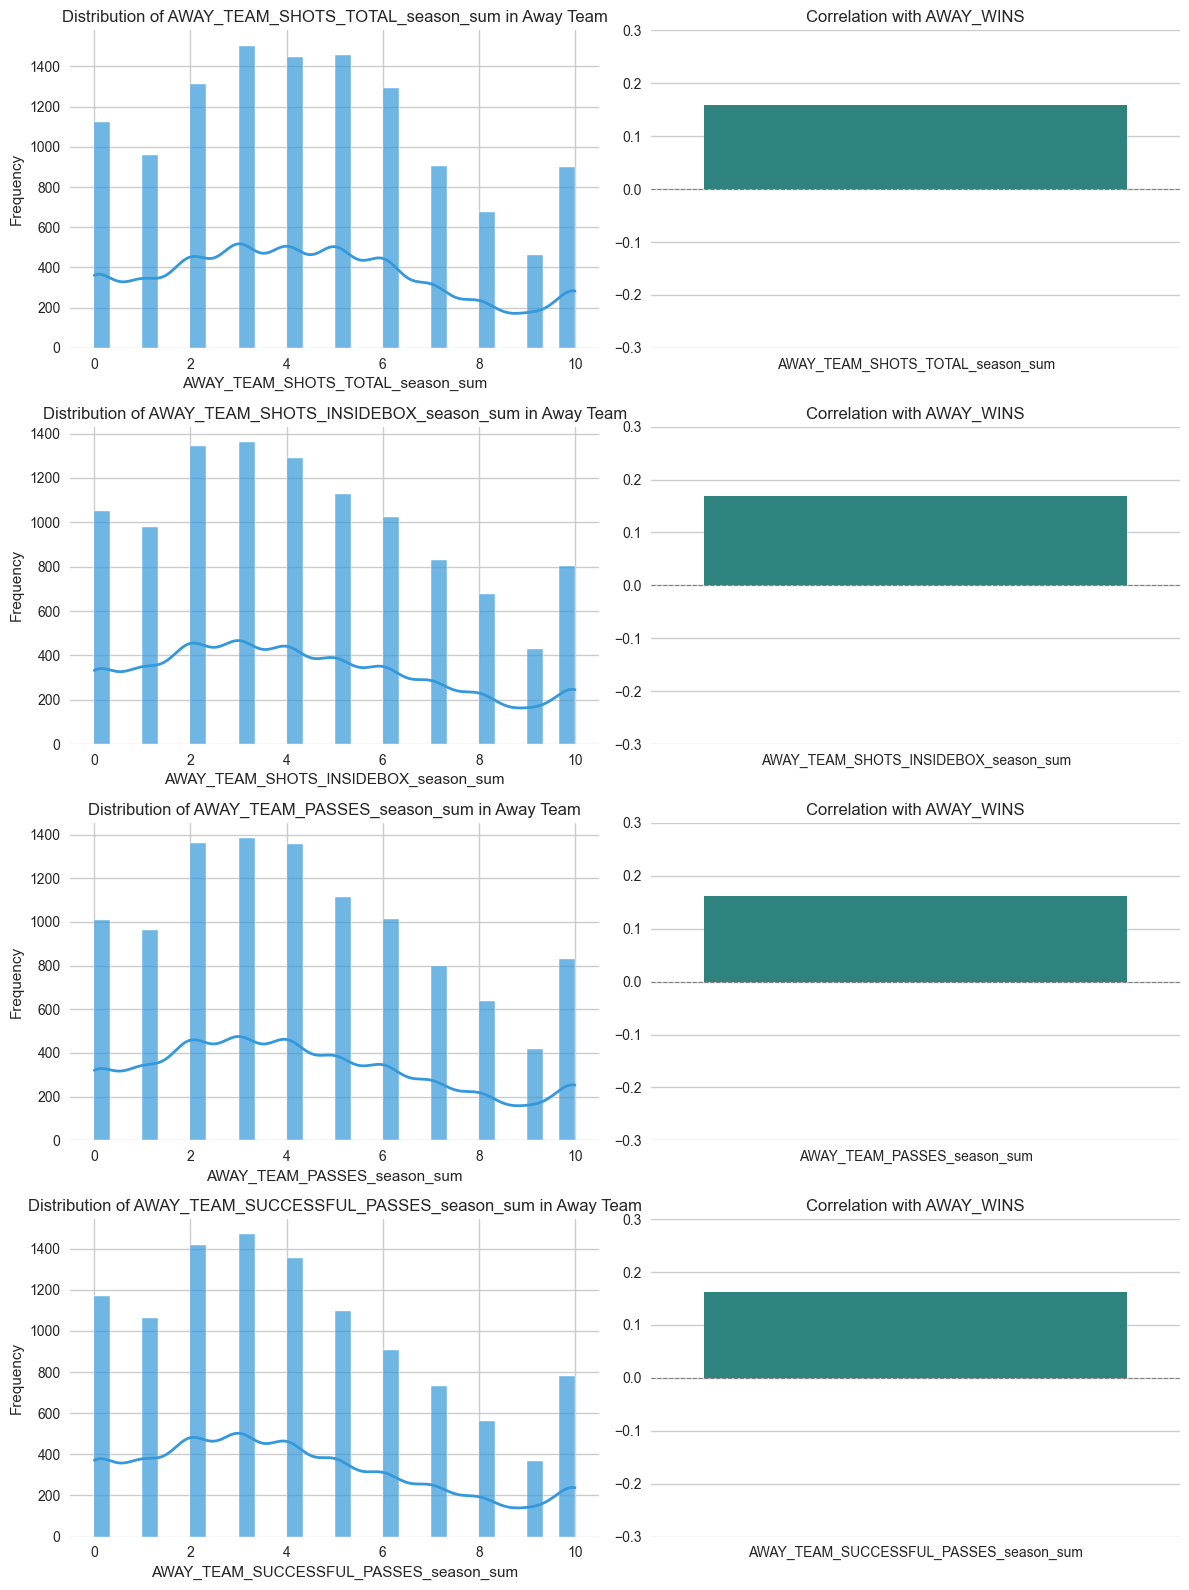

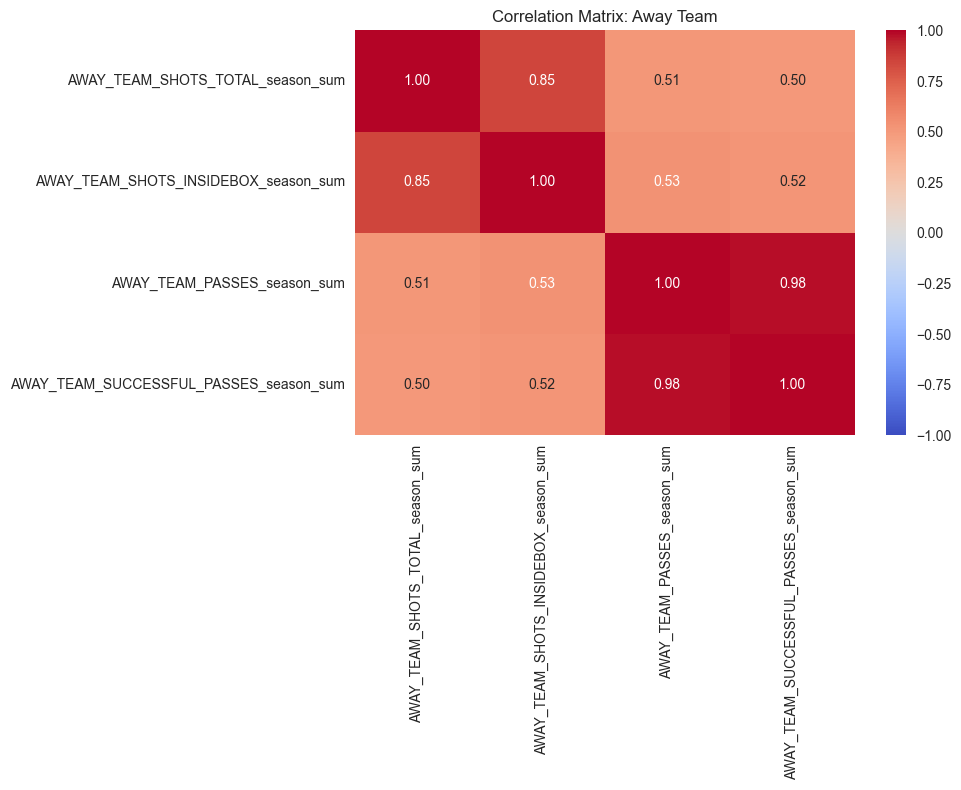

In [122]:
# Ensure inline plotting
%matplotlib inline



# Configure plotting style
plt.style.use('seaborn-v0_8')


# Function to configure common plot settings
def configure_plot_style():
    plt.rcParams.update({
        'figure.figsize': (10, 6),
        'axes.facecolor': 'white',
        'axes.grid': True,
        'grid.color': '#CCCCCC',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'lines.linewidth': 2
    })
    colors = sns.color_palette("colorblind")
    sns.set_palette(colors)

def plot_correlation_matrix(df, features, title):
    corr_matrix = df[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                annot=True,
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                center=0,
                fmt='.2f')
    plt.title(f'Correlation Matrix: {title}')
    plt.tight_layout()
    plt.show()

def merge_target_with_data(df, y_train_away_win, target_columns=['AWAY_WINS']):
    """Merge the target columns with the dataset."""
    # Reset index to make ID a column
    df_reset = df.reset_index()
    y_train_reset = y_train_away_win.reset_index()
    
    # Merge on ID
    merged = df_reset.merge(y_train_reset[['ID'] + target_columns], on='ID', how='inner')
    
    # Set ID back as index
    merged.set_index('ID', inplace=True)
    return merged

# Utility functions for EDA
def inspect_data_summary(df, dataset_name):
    print(f"--- {dataset_name} Summary ---")
    print(f"Shape: {df.shape}")
    print(f"Missing Values:\n{df.isnull().sum().sort_values(ascending=False).head(10)}")
    print(f"First Few Rows:\n{df.head()}")
    print(f"--- End of {dataset_name} Summary ---\n")

def plot_distribution_and_correlations(df, columns, target_column, dataset_name):
    configure_plot_style()
    
    # Grouped plots: Distribution and Correlation
    num_cols = len(columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 4 * num_cols))
    
    for i, column in enumerate(columns):
        if column in df.columns:
            # Distribution plot
            sns.histplot(df[column].dropna(), kde=True, bins=30, color='#3498db', alpha=0.7, ax=axes[i, 0])
            axes[i, 0].set_title(f"Distribution of {column} in {dataset_name}")
            axes[i, 0].set_xlabel(column)
            axes[i, 0].set_ylabel("Frequency")
            
            # Correlation bar
            correlation = df[column].corr(df[target_column])
            sns.barplot(x=[column], y=[correlation], ax=axes[i, 1], palette='viridis')
            axes[i, 1].set_title(f"Correlation with {target_column}")
            axes[i, 1].set_ylim(-0.3, 0.3)  # Adjusted y-axis limits
            axes[i, 1].axhline(0, color='grey', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

# Comprehensive player-level analysis
def player_eda(home_player, away_player, y_train_away_win):
    # Specify datasets with respective target columns
    player_datasets = {
        'Home Player': {'data': home_player, 'prefix': 'HOME_', 'target': 'HOME_WINS'},
        'Away Player': {'data': away_player, 'prefix': 'AWAY_', 'target': 'AWAY_WINS'}
    }

    important_player_metrics = [
        'PLAYER_ACCURATE_CROSSES_season_sum',
        'PLAYER_ACCURATE_PASSES_season_sum',
        'PLAYER_AERIALS_WON_season_sum',
        'PLAYER_ASSISTS_season_sum',
        'PLAYER_BIG_CHANCES_CREATED_season_sum'
    ]

    for name, content in player_datasets.items():
        prefixed_metrics = [content['prefix'] + metric for metric in important_player_metrics]
        df = merge_target_with_data(content['data'], y_train_away_win, target_columns=[content['target']])
        inspect_data_summary(df, name)
        plot_distribution_and_correlations(df, prefixed_metrics, content['target'], name)
        plot_correlation_matrix(df, prefixed_metrics, name)

# Comprehensive team-level analysis
def team_eda(home_team, away_team, y_train_away_win):
    # Specify datasets with respective target columns
    team_datasets = {
        'Home Team': {'data': home_team, 'prefix': 'HOME_', 'target': 'HOME_WINS'},
        'Away Team': {'data': away_team, 'prefix': 'AWAY_', 'target': 'AWAY_WINS'}
    }

    important_team_metrics = [
        'TEAM_SHOTS_TOTAL_season_sum',
        'TEAM_SHOTS_INSIDEBOX_season_sum',
        'TEAM_PASSES_season_sum',
        'TEAM_SUCCESSFUL_PASSES_season_sum'
    ]

    for name, content in team_datasets.items():
        prefixed_metrics = [content['prefix'] + metric for metric in important_team_metrics]
        df = merge_target_with_data(content['data'], y_train_away_win, target_columns=[content['target']])
        inspect_data_summary(df, name)
        plot_distribution_and_correlations(df, prefixed_metrics, content['target'], name)
        plot_correlation_matrix(df, prefixed_metrics, name)

# Running EDA
player_eda(train_home_player, train_away_player, y_train_away_win)
team_eda(train_home_team, train_away_team, y_train_away_win)


## Benchmark Model

In [123]:
train_home = train_home_team.iloc[:,2:]
train_away = train_away_team.iloc[:,2:]

train_data = pd.concat([train_home, train_away], join='inner', axis=1)
train_scores = y_train_away_win.loc[train_data.index]

# 2. Handle infinite values
train_data = train_data.replace({np.inf: np.nan, -np.inf: np.nan})

# 3. Get target variable
train_new_y = train_scores['AWAY_WINS']

# 4. Split data
X_train, X_test, y_train_away_win, y_test = train_test_split(
    train_data, 
    train_new_y, 
    train_size=0.8, 
    random_state=42
)

X_train, X_valid, y_train_away_win, y_valid = train_test_split(
    X_train, 
    y_train_away_win, 
    train_size=0.8, 
    random_state=42
)

# 5. Create XGBoost matrices - remove the select_dtypes step since we already handled it
d_train = xgb.DMatrix(X_train.replace({0: np.nan}), y_train_away_win)
d_valid = xgb.DMatrix(X_valid.replace({0: np.nan}), y_valid)

# 6. Rest of your code remains the same
xgb_params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'max_depth': 8,
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric': 'mlogloss'
}

# 6. Training
num_rounds = 10000
watchlist = [(d_train, 'train'), (d_valid, 'eval')]
model = xgb.train(
    params=xgb_params,
    dtrain=d_train,
    num_boost_round=num_rounds,
    evals=watchlist,
    early_stopping_rounds=100
)

# 7. Predictions
X_test_clean = X_test.select_dtypes(exclude='object').replace({0: np.nan})
d_test = xgb.DMatrix(X_test_clean)
predictions = model.predict(d_test, iteration_range=(0, model.best_iteration))

[0]	train-mlogloss:0.68338	eval-mlogloss:0.68785
[1]	train-mlogloss:0.67389	eval-mlogloss:0.68266
[2]	train-mlogloss:0.66467	eval-mlogloss:0.67757
[3]	train-mlogloss:0.65574	eval-mlogloss:0.67304
[4]	train-mlogloss:0.64724	eval-mlogloss:0.66849
[5]	train-mlogloss:0.63894	eval-mlogloss:0.66438
[6]	train-mlogloss:0.63052	eval-mlogloss:0.66062
[7]	train-mlogloss:0.62230	eval-mlogloss:0.65697
[8]	train-mlogloss:0.61454	eval-mlogloss:0.65359
[9]	train-mlogloss:0.60701	eval-mlogloss:0.65015
[10]	train-mlogloss:0.59949	eval-mlogloss:0.64682
[11]	train-mlogloss:0.59224	eval-mlogloss:0.64347
[12]	train-mlogloss:0.58520	eval-mlogloss:0.64026
[13]	train-mlogloss:0.57876	eval-mlogloss:0.63741
[14]	train-mlogloss:0.57188	eval-mlogloss:0.63467
[15]	train-mlogloss:0.56536	eval-mlogloss:0.63191
[16]	train-mlogloss:0.55888	eval-mlogloss:0.62946
[17]	train-mlogloss:0.55254	eval-mlogloss:0.62681
[18]	train-mlogloss:0.54669	eval-mlogloss:0.62444
[19]	train-mlogloss:0.54078	eval-mlogloss:0.62231
[20]	train

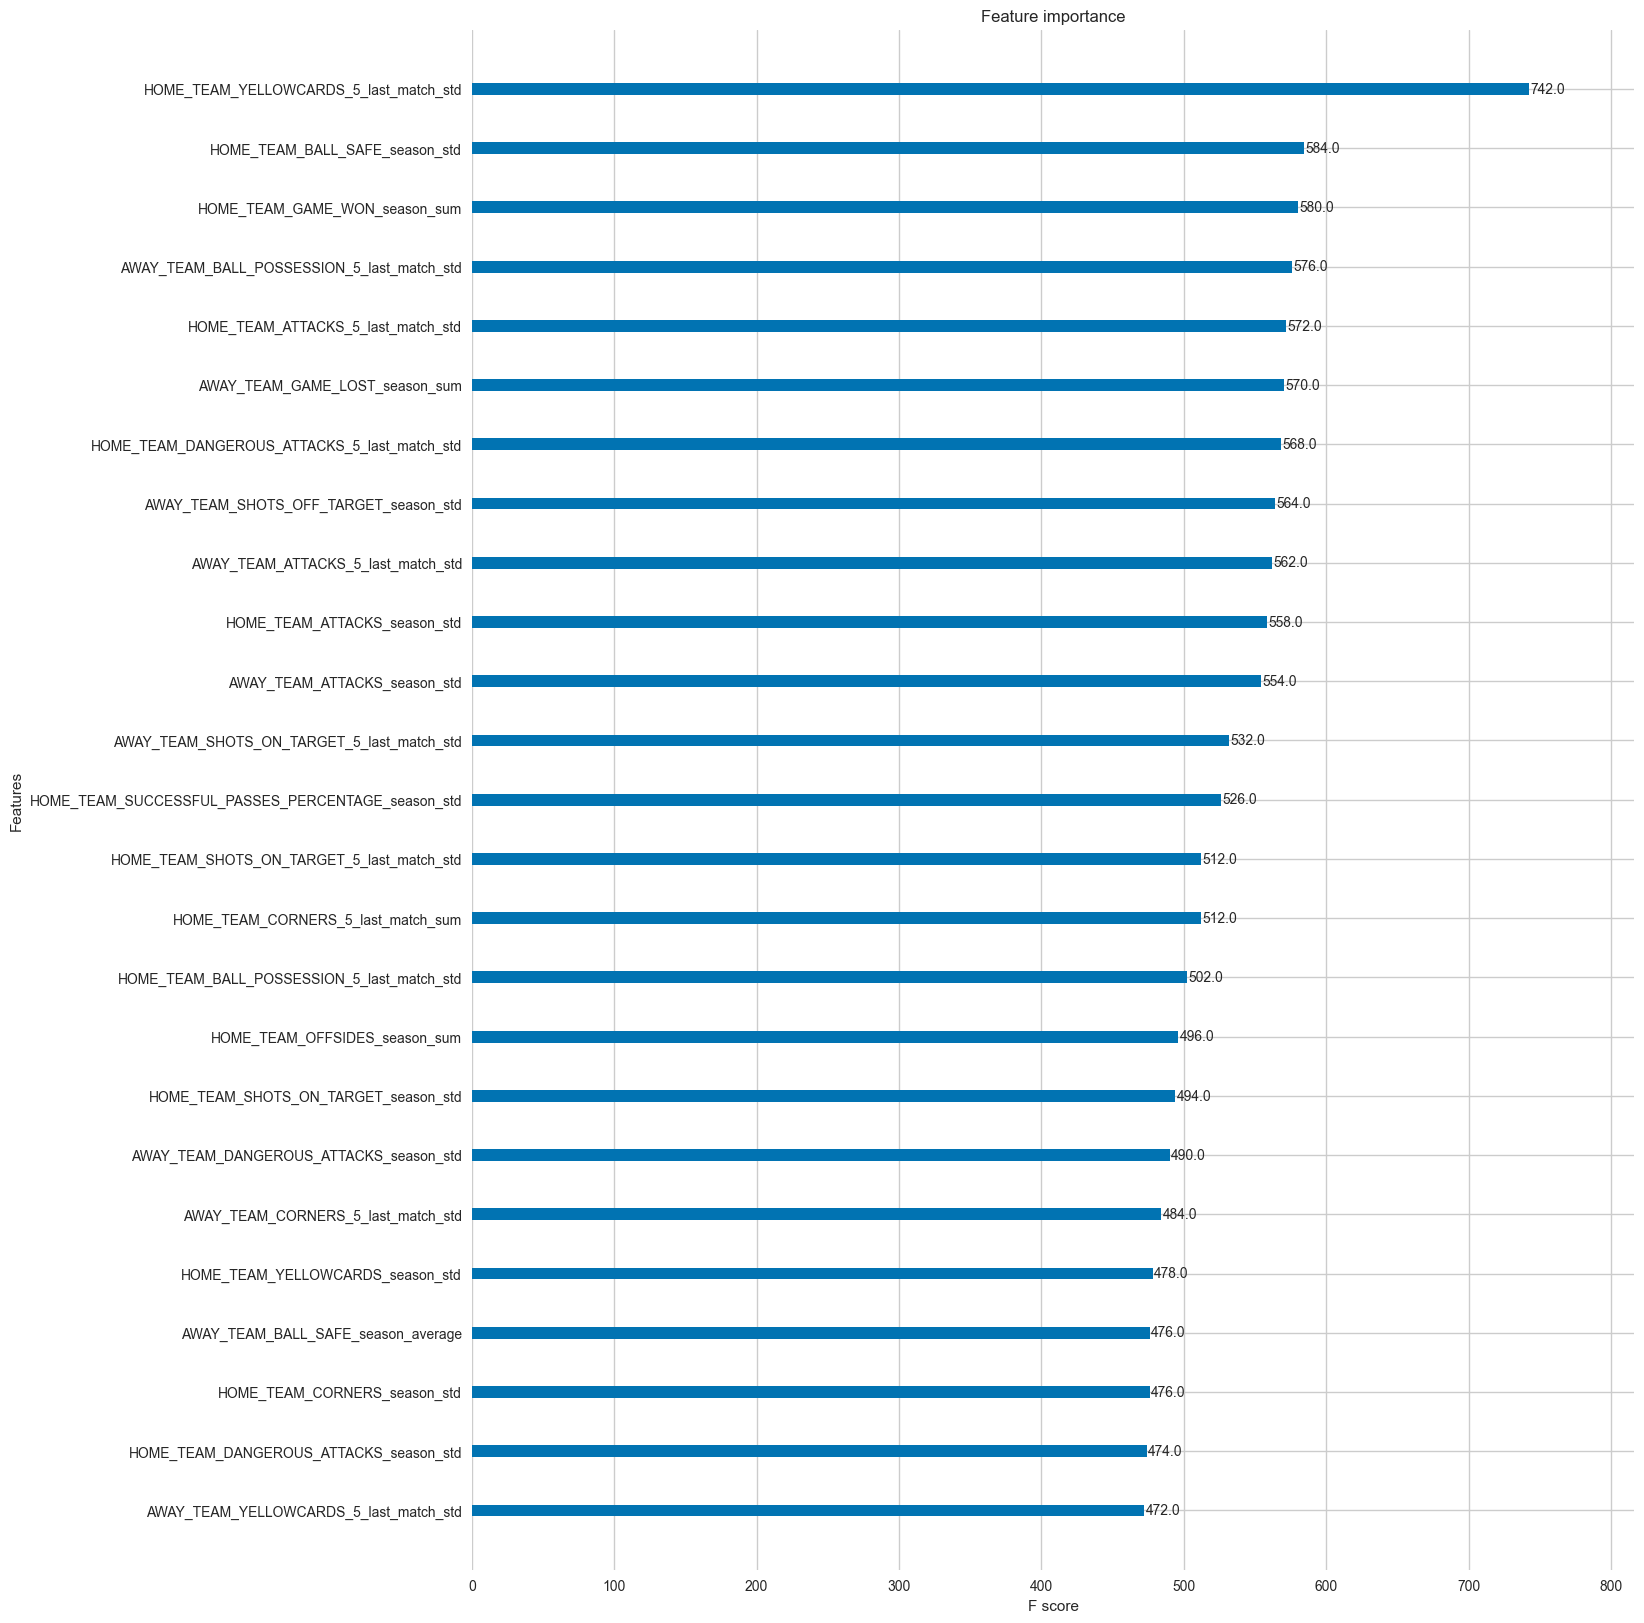

In [124]:
xgb.plot_importance(model, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)

In [125]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)

np.float64(0.4401)

In [126]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = model.predict(X_test_xgb, iteration_range=(0, model.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


np.float64(0.4742)

## Data Preprocessing and Feature Engineering

In [127]:


def preprocess_features(home_team: pd.DataFrame, away_team: pd.DataFrame) -> pd.DataFrame:
    """Generate cleaned and engineered features."""
    
    # Keep only numeric columns
    home_team = home_team.select_dtypes(exclude='object')
    away_team = away_team.select_dtypes(exclude='object')
    
    # Create base feature set
    features = pd.DataFrame(index=home_team.index)
    
    # Add raw features
    for col in home_team.columns:
        if col.startswith('HOME_'):
            base_name = col.replace('HOME_', '')
            away_col = f'AWAY_{base_name}'
            
            if away_col in away_team.columns:
                # Add individual features
                features[col] = home_team[col]
                features[away_col] = away_team[away_col]
                
                # Add difference feature
                features[f'{base_name}_DIFF'] = home_team[col] - away_team[away_col]
                
                # Add ratio feature (handling zeros)
                denom = away_team[away_col].replace(0, 1)
                features[f'{base_name}_RATIO'] = home_team[col] / denom
    
    # Handle missing values
    features = features.fillna(0)
    
    # Calculate variance for all features
    variance = features.var()
    
    # Remove constant/low variance features
    features = features[features.columns[variance > 0.01]]
    
    # Validate preprocessing
    validate_preprocessing(features, variance)

    # Plot feature distributions
    #plot_feature_distributions(features)

    return features

def validate_preprocessing(features: pd.DataFrame, variance: pd.Series) -> None:
    # Check for any remaining missing values
    assert features.isna().sum().sum() == 0, "Found missing values"
    
    # Check for infinite values
    assert np.isinf(features).sum().sum() == 0, "Found infinite values"
    
    # Print shape before/after to see impact of feature removal
    print(f"Final feature shape: {features.shape}")
    print(f"Features removed: {len(variance[variance <= 0.01])}")

def plot_feature_distributions(features: pd.DataFrame) -> None:
    plt.figure(figsize=(15, 5))
    
    # Distribution of differences
    diff_cols = [col for col in features.columns if col.endswith('_DIFF')]
    features[diff_cols].boxplot()
    plt.xticks(rotation=90)
    plt.title('Distribution of Difference Features')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap of key features
    plt.figure(figsize=(10, 10))
    sns.heatmap(features.corr(), cmap='RdBu', center=0)
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()


processed_features = preprocess_features(train_home_team, train_away_team)
processed_features.head()

Final feature shape: (12303, 560)
Features removed: 0


,HOME_TEAM_SHOTS_TOTAL_season_sum,AWAY_TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_TOTAL_season_sum_DIFF,TEAM_SHOTS_TOTAL_season_sum_RATIO,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,AWAY_TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum_DIFF,TEAM_SHOTS_INSIDEBOX_season_sum_RATIO,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,AWAY_TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum_DIFF,TEAM_SHOTS_OFF_TARGET_season_sum_RATIO,HOME_TEAM_SHOTS_ON_TARGET_season_sum,AWAY_TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum_DIFF,TEAM_SHOTS_ON_TARGET_season_sum_RATIO,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum_DIFF,TEAM_SHOTS_OUTSIDEBOX_season_sum_RATIO,HOME_TEAM_PASSES_season_sum,AWAY_TEAM_PASSES_season_sum,TEAM_PASSES_season_sum_DIFF,TEAM_PASSES_season_sum_RATIO,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,AWAY_TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum_DIFF,TEAM_SUCCESSFUL_PASSES_season_sum_RATIO,HOME_TEAM_SAVES_season_sum,AWAY_TEAM_SAVES_season_sum,TEAM_SAVES_season_sum_DIFF,TEAM_SAVES_season_sum_RATIO,HOME_TEAM_CORNERS_season_sum,AWAY_TEAM_CORNERS_season_sum,TEAM_CORNERS_season_sum_DIFF,TEAM_CORNERS_season_sum_RATIO,HOME_TEAM_FOULS_season_sum,AWAY_TEAM_FOULS_season_sum,TEAM_FOULS_season_sum_DIFF,TEAM_FOULS_season_sum_RATIO,HOME_TEAM_YELLOWCARDS_season_sum,AWAY_TEAM_YELLOWCARDS_season_sum,TEAM_YELLOWCARDS_season_sum_DIFF,TEAM_YELLOWCARDS_season_sum_RATIO,HOME_TEAM_REDCARDS_season_sum,AWAY_TEAM_REDCARDS_season_sum,TEAM_REDCARDS_season_sum_DIFF,TEAM_REDCARDS_season_sum_RATIO,HOME_TEAM_OFFSIDES_season_sum,AWAY_TEAM_OFFSIDES_season_sum,TEAM_OFFSIDES_season_sum_DIFF,TEAM_OFFSIDES_season_sum_RATIO,HOME_TEAM_ATTACKS_season_sum,AWAY_TEAM_ATTACKS_season_sum,TEAM_ATTACKS_season_sum_DIFF,TEAM_ATTACKS_season_sum_RATIO,HOME_TEAM_PENALTIES_season_sum,AWAY_TEAM_PENALTIES_season_sum,TEAM_PENALTIES_season_sum_DIFF,TEAM_PENALTIES_season_sum_RATIO,HOME_TEAM_SUBSTITUTIONS_season_sum,AWAY_TEAM_SUBSTITUTIONS_season_sum,TEAM_SUBSTITUTIONS_season_sum_DIFF,TEAM_SUBSTITUTIONS_season_sum_RATIO,HOME_TEAM_BALL_SAFE_season_sum,AWAY_TEAM_BALL_SAFE_season_sum,TEAM_BALL_SAFE_season_sum_DIFF,TEAM_BALL_SAFE_season_sum_RATIO,HOME_TEAM_DANGEROUS_ATTACKS_season_sum,AWAY_TEAM_DANGEROUS_ATTACKS_season_sum,TEAM_DANGEROUS_ATTACKS_season_sum_DIFF,TEAM_DANGEROUS_ATTACKS_season_sum_RATIO,HOME_TEAM_INJURIES_season_sum,AWAY_TEAM_INJURIES_season_sum,TEAM_INJURIES_season_sum_DIFF,TEAM_INJURIES_season_sum_RATIO,HOME_TEAM_GOALS_season_sum,AWAY_TEAM_GOALS_season_sum,TEAM_GOALS_season_sum_DIFF,TEAM_GOALS_season_sum_RATIO,HOME_TEAM_GAME_WON_season_sum,AWAY_TEAM_GAME_WON_season_sum,TEAM_GAME_WON_season_sum_DIFF,TEAM_GAME_WON_season_sum_RATIO,HOME_TEAM_GAME_DRAW_season_sum,AWAY_TEAM_GAME_DRAW_season_sum,TEAM_GAME_DRAW_season_sum_DIFF,TEAM_GAME_DRAW_season_sum_RATIO,HOME_TEAM_GAME_LOST_season_sum,AWAY_TEAM_GAME_LOST_season_sum,TEAM_GAME_LOST_season_sum_DIFF,TEAM_GAME_LOST_season_sum_RATIO,HOME_TEAM_SHOTS_TOTAL_season_average,AWAY_TEAM_SHOTS_TOTAL_season_average,TEAM_SHOTS_TOTAL_season_average_DIFF,TEAM_SHOTS_TOTAL_season_average_RATIO,HOME_TEAM_SHOTS_INSIDEBOX_season_average,AWAY_TEAM_SHOTS_INSIDEBOX_season_average,TEAM_SHOTS_INSIDEBOX_season_average_DIFF,TEAM_SHOTS_INSIDEBOX_season_average_RATIO,HOME_TEAM_SHOTS_OFF_TARGET_season_average,AWAY_TEAM_SHOTS_OFF_TARGET_season_average,TEAM_SHOTS_OFF_TARGET_season_average_DIFF,TEAM_SHOTS_OFF_TARGET_season_average_RATIO,HOME_TEAM_SHOTS_ON_TARGET_season_average,AWAY_TEAM_SHOTS_ON_TARGET_season_average,TEAM_SHOTS_ON_TARGET_season_average_DIFF,TEAM_SHOTS_ON_TARGET_season_average_RATIO,HOME_TEAM_SHOTS_OUTSIDEBOX_season_average,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_average,TEAM_SHOTS_OUTSIDEBOX_season_average_DIFF,TEAM_SHOTS_OUTSIDEBOX_season_average_RATIO,HOME_TEAM_PASSES_season_average,AWAY_TEAM_PASSES_season_average,TEAM_PASSES_season_average_DIFF,TEAM_PASSES_season_average_RATIO,HOME_TEAM_SUCCESSFUL_PASSES_season_average,AWAY_TEAM_SUCCESSFUL_PASSES

In [128]:
def handle_outliers(features: pd.DataFrame, threshold: float = 1.5) -> pd.DataFrame:
    cleaned = features.copy()
    
    for column in features.columns:
        q1 = features[column].quantile(0.25)
        q3 = features[column].quantile(0.75)
        iqr = q3 - q1
        
        lower_bound = q1 - (threshold * iqr)
        upper_bound = q3 + (threshold * iqr)
        
        # Cap outliers at boundaries instead of removing
        cleaned[column] = features[column].clip(lower_bound, upper_bound)
    
    # Validate outlier handling
    outliers_before = ((features < features.quantile(0.25) - 1.5 * (features.quantile(0.75) - features.quantile(0.25))) | 
                      (features > features.quantile(0.75) + 1.5 * (features.quantile(0.75) - features.quantile(0.25)))).sum()
    outliers_after = ((cleaned < cleaned.quantile(0.25) - 1.5 * (cleaned.quantile(0.75) - cleaned.quantile(0.25))) | 
                     (cleaned > cleaned.quantile(0.75) + 1.5 * (cleaned.quantile(0.75) - cleaned.quantile(0.25)))).sum()
    
    print(f"Total outliers before: {outliers_before.sum()}")
    print(f"Total outliers after: {outliers_after.sum()}")
    
    return cleaned

processed_features = handle_outliers(processed_features)

Total outliers before: 192676
Total outliers after: 0


In [129]:
processed_features.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,AWAY_TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_TOTAL_season_sum_DIFF,TEAM_SHOTS_TOTAL_season_sum_RATIO,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,AWAY_TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum_DIFF,TEAM_SHOTS_INSIDEBOX_season_sum_RATIO,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,AWAY_TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum_DIFF,TEAM_SHOTS_OFF_TARGET_season_sum_RATIO,HOME_TEAM_SHOTS_ON_TARGET_season_sum,AWAY_TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum_DIFF,TEAM_SHOTS_ON_TARGET_season_sum_RATIO,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum_DIFF,TEAM_SHOTS_OUTSIDEBOX_season_sum_RATIO,HOME_TEAM_PASSES_season_sum,AWAY_TEAM_PASSES_season_sum,TEAM_PASSES_season_sum_DIFF,TEAM_PASSES_season_sum_RATIO,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,AWAY_TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum_DIFF,TEAM_SUCCESSFUL_PASSES_season_sum_RATIO,HOME_TEAM_SAVES_season_sum,AWAY_TEAM_SAVES_season_sum,TEAM_SAVES_season_sum_DIFF,TEAM_SAVES_season_sum_RATIO,HOME_TEAM_CORNERS_season_sum,AWAY_TEAM_CORNERS_season_sum,TEAM_CORNERS_season_sum_DIFF,TEAM_CORNERS_season_sum_RATIO,HOME_TEAM_FOULS_season_sum,AWAY_TEAM_FOULS_season_sum,TEAM_FOULS_season_sum_DIFF,TEAM_FOULS_season_sum_RATIO,HOME_TEAM_YELLOWCARDS_season_sum,AWAY_TEAM_YELLOWCARDS_season_sum,TEAM_YELLOWCARDS_season_sum_DIFF,TEAM_YELLOWCARDS_season_sum_RATIO,HOME_TEAM_REDCARDS_season_sum,AWAY_TEAM_REDCARDS_season_sum,TEAM_REDCARDS_season_sum_DIFF,TEAM_REDCARDS_season_sum_RATIO,HOME_TEAM_OFFSIDES_season_sum,AWAY_TEAM_OFFSIDES_season_sum,TEAM_OFFSIDES_season_sum_DIFF,TEAM_OFFSIDES_season_sum_RATIO,HOME_TEAM_ATTACKS_season_sum,AWAY_TEAM_ATTACKS_season_sum,TEAM_ATTACKS_season_sum_DIFF,TEAM_ATTACKS_season_sum_RATIO,HOME_TEAM_PENALTIES_season_sum,AWAY_TEAM_PENALTIES_season_sum,TEAM_PENALTIES_season_sum_DIFF,TEAM_PENALTIES_season_sum_RATIO,HOME_TEAM_SUBSTITUTIONS_season_sum,AWAY_TEAM_SUBSTITUTIONS_season_sum,TEAM_SUBSTITUTIONS_season_sum_DIFF,TEAM_SUBSTITUTIONS_season_sum_RATIO,HOME_TEAM_BALL_SAFE_season_sum,AWAY_TEAM_BALL_SAFE_season_sum,TEAM_BALL_SAFE_season_sum_DIFF,TEAM_BALL_SAFE_season_sum_RATIO,HOME_TEAM_DANGEROUS_ATTACKS_season_sum,AWAY_TEAM_DANGEROUS_ATTACKS_season_sum,TEAM_DANGEROUS_ATTACKS_season_sum_DIFF,TEAM_DANGEROUS_ATTACKS_season_sum_RATIO,HOME_TEAM_INJURIES_season_sum,AWAY_TEAM_INJURIES_season_sum,TEAM_INJURIES_season_sum_DIFF,TEAM_INJURIES_season_sum_RATIO,HOME_TEAM_GOALS_season_sum,AWAY_TEAM_GOALS_season_sum,TEAM_GOALS_season_sum_DIFF,TEAM_GOALS_season_sum_RATIO,HOME_TEAM_GAME_WON_season_sum,AWAY_TEAM_GAME_WON_season_sum,TEAM_GAME_WON_season_sum_DIFF,TEAM_GAME_WON_season_sum_RATIO,HOME_TEAM_GAME_DRAW_season_sum,AWAY_TEAM_GAME_DRAW_season_sum,TEAM_GAME_DRAW_season_sum_DIFF,TEAM_GAME_DRAW_season_sum_RATIO,HOME_TEAM_GAME_LOST_season_sum,AWAY_TEAM_GAME_LOST_season_sum,TEAM_GAME_LOST_season_sum_DIFF,TEAM_GAME_LOST_season_sum_RATIO,HOME_TEAM_SHOTS_TOTAL_season_average,AWAY_TEAM_SHOTS_TOTAL_season_average,TEAM_SHOTS_TOTAL_season_average_DIFF,TEAM_SHOTS_TOTAL_season_average_RATIO,HOME_TEAM_SHOTS_INSIDEBOX_season_average,AWAY_TEAM_SHOTS_INSIDEBOX_season_average,TEAM_SHOTS_INSIDEBOX_season_average_DIFF,TEAM_SHOTS_INSIDEBOX_season_average_RATIO,HOME_TEAM_SHOTS_OFF_TARGET_season_average,AWAY_TEAM_SHOTS_OFF_TARGET_season_average,TEAM_SHOTS_OFF_TARGET_season_average_DIFF,TEAM_SHOTS_OFF_TARGET_season_average_RATIO,HOME_TEAM_SHOTS_ON_TARGET_season_average,AWAY_TEAM_SHOTS_ON_TARGET_season_average,TEAM_SHOTS_ON_TARGET_season_average_DIFF,TEAM_SHOTS_ON_TARGET_season_average_RATIO,HOME_TEAM_SHOTS_OUTSIDEBOX_season_average,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_average,TEAM_SHOTS_OUTSIDEBOX_season_average_DIFF,TEAM_SHOTS_OUTSIDEBOX_season_average_RATIO,HOME_TEAM_PASSES_season_average,AWAY_TEAM_PASSES_season_average,TEAM_PASSES_season_average_DIFF,TEAM_PASSES_season_average_RATIO,HOME_TEAM_SUCCESSFUL_PASSES_season_average,AWAY_TEAM_SUCCESSFUL_PASSES

Found 30 offensive features and 18 defensive features
Total outliers before: 376
Total outliers after: 376

Top 20 most important features:
                                         feature  importance
191          TEAM_GAME_LOST_season_average_RATIO    0.004523
83                TEAM_GAME_WON_season_sum_RATIO    0.004441
91               TEAM_GAME_LOST_season_sum_RATIO    0.004016
182            TEAM_GAME_WON_season_average_DIFF    0.003777
183           TEAM_GAME_WON_season_average_RATIO    0.003743
106     TEAM_SHOTS_ON_TARGET_season_average_DIFF    0.003690
90                TEAM_GAME_LOST_season_sum_DIFF    0.003597
171  TEAM_DANGEROUS_ATTACKS_season_average_RATIO    0.003452
135    TEAM_BALL_POSSESSION_season_average_RATIO    0.003371
94          TEAM_SHOTS_TOTAL_season_average_DIFF    0.003361
71       TEAM_DANGEROUS_ATTACKS_season_sum_RATIO    0.003340
6           TEAM_SHOTS_INSIDEBOX_season_sum_DIFF    0.003321
155            TEAM_ATTACKS_season_average_RATIO    0.003315
82    

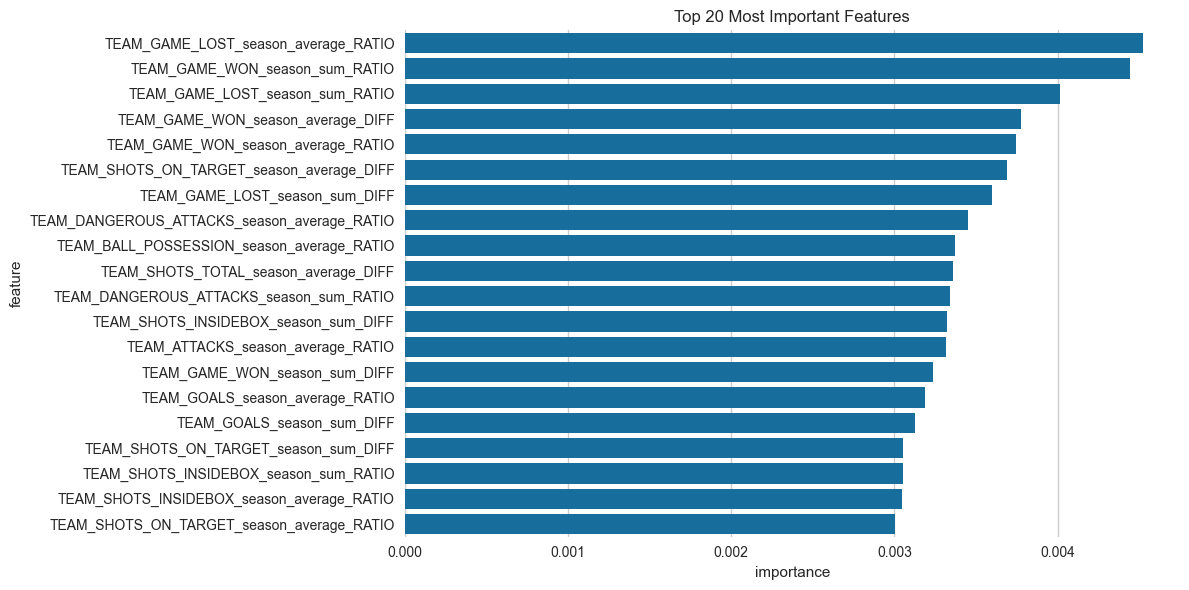

In [130]:
# Feature Interactions

# 1. Select meaningful base features using actual column patterns
offensive_base_metrics = ['SHOTS_TOTAL', 'SHOTS_ON_TARGET', 'GOALS', 'ATTACKS', 'DANGEROUS_ATTACKS']
defensive_base_metrics = ['SAVES', 'BALL_SAFE', 'FOULS']
agg_types = ['season_sum', 'season_average', '5_last_match_average']

# 2. Generate feature lists
offensive_features = []
defensive_features = []

for metric in offensive_base_metrics:
    for agg in agg_types:
        for prefix in ['HOME_TEAM_', 'AWAY_TEAM_']:
            col = f"{prefix}{metric}_{agg}"
            if col in processed_features.columns:
                offensive_features.append(col)

for metric in defensive_base_metrics:
    for agg in agg_types:
        for prefix in ['HOME_TEAM_', 'AWAY_TEAM_']:
            col = f"{prefix}{metric}_{agg}"
            if col in processed_features.columns:
                defensive_features.append(col)

print(f"Found {len(offensive_features)} offensive features and {len(defensive_features)} defensive features")

# 3. Generate meaningful interactions (limit to top features)
interaction_features = {}
for off_feat in offensive_features[:5]:  # Top 5 offensive features
    for def_feat in defensive_features[:5]:  # Top 5 defensive features
        interaction_name = f"INT_{off_feat.split('_')[1]}_{def_feat.split('_')[1]}"
        interaction_features[interaction_name] = processed_features[off_feat] * processed_features[def_feat]

# 4. Convert to DataFrame and check distributions
interaction_df = pd.DataFrame(interaction_features)

# 5. Handle extreme values in interactions
interaction_df = handle_outliers(interaction_df, threshold=2.0)  # Using existing function

# 6. Merge with original features
final_features = pd.concat([processed_features, interaction_df], axis=1)

# 7. Validate usefulness of interactions
# Create proper train/test split first with all three target classes
X_train, X_test, y_train, y_test = train_test_split(
    final_features, 
    y_train[['HOME_WINS', 'DRAW', 'AWAY_WINS']],  # Use all three target columns
    test_size=0.2, 
    random_state=42
)

# Train a Random Forest for feature importance with multi-class target
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Convert y_train to single column of class indices
y_train_classes = np.argmax(y_train.values, axis=1)
rf.fit(X_train, y_train_classes)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': final_features.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [139]:
# Feature Selection based on importance
TOP_N_FEATURES = 50  # Adjust based on feature importance distribution
selected_features = feature_importance.head(TOP_N_FEATURES)['feature'].tolist()
X_selected = final_features[selected_features]

# Normalize/Scale features since we have ratios and raw values mixed
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

## LightGBM Model

In [141]:
# Feature Selection based on importance
TOP_N_FEATURES = 50  # Adjust based on feature importance distribution
selected_features = feature_importance.head(TOP_N_FEATURES)['feature'].tolist()
X_selected = final_features[selected_features]

# Normalize/Scale features since we have ratios and raw values mixed
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

# Create proper train/test split first with all three target classes
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_train[['HOME_WINS', 'DRAW', 'AWAY_WINS']],  # Use all three target columns
    test_size=0.2, 
    random_state=42
)



# LightGBM Training
lgb_train = lgb.Dataset(X_train, label=y_train_classes)
lgb_val = lgb.Dataset(X_test, label=np.argmax(y_test.values, axis=1))
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'max_depth': 6
}
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    early_stopping_rounds=50,
    verbose_eval=False
)
preds = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(preds, axis=1))
print("LightGBM accuracy:", lgb_accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [12303, 9842]